# Demo: GPSR Using Bingo

## (1) Import Base Packages ##

In [1]:
import numpy as np;np.seterr(all="ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import display, clear_output
from tqdm import tqdm

## (2) Import Relevant Bingo Classes ##

In [2]:
#Classes for Genetic Programming (GP)
from bingo.symbolic_regression import ComponentGenerator
from bingo.evolutionary_optimizers.island import Island
from bingo.symbolic_regression.agraph.agraph import AGraph
from bingo.stats.pareto_front import ParetoFront

#Classes for the EVALUATION stage of GPSR
from bingo.symbolic_regression import ExplicitRegression, \
                                      ExplicitTrainingData
from bingo.evaluation.evaluation import Evaluation
from bingo.local_optimizers.continuous_local_opt import ContinuousLocalOptimization

#Classes for Baysian fitness
from bingo.symbolic_regression.bayes_fitness.bayes_fitness_function import BayesFitnessFunction

#Classes for the EVOLUTION stage of GPSR
from bingo.symbolic_regression import AGraphGenerator, \
                                      AGraphCrossover, \
                                      AGraphMutation

#Classes for the Bayesian SELECTION stage of GPSR
from bingo.evolutionary_algorithms.generalized_crowding import \
                                      GeneralizedCrowdingEA
from bingo.selection.bayes_crowding import BayesCrowding

## (2) Initialize GPSR Hyperparameters ##
Note: Hyperparameters relating to the criterion check and information storage not present in this code. Refer to BingoExample/example_code/main_script.py for additional information.

In [3]:
POPULATION_SIZE = 40
STACK_SIZE = 24
MAX_GENERATIONS = 100

## (2) Initialize parameters for SMC (Bayesian Fitness)

In [4]:
smc_hyperparams = {'num_particles':10,
                   'mcmc_steps':10,
                   'ess_threshold':0.75}

## (3) Make Training Data ##

<IPython.core.display.Javascript object>


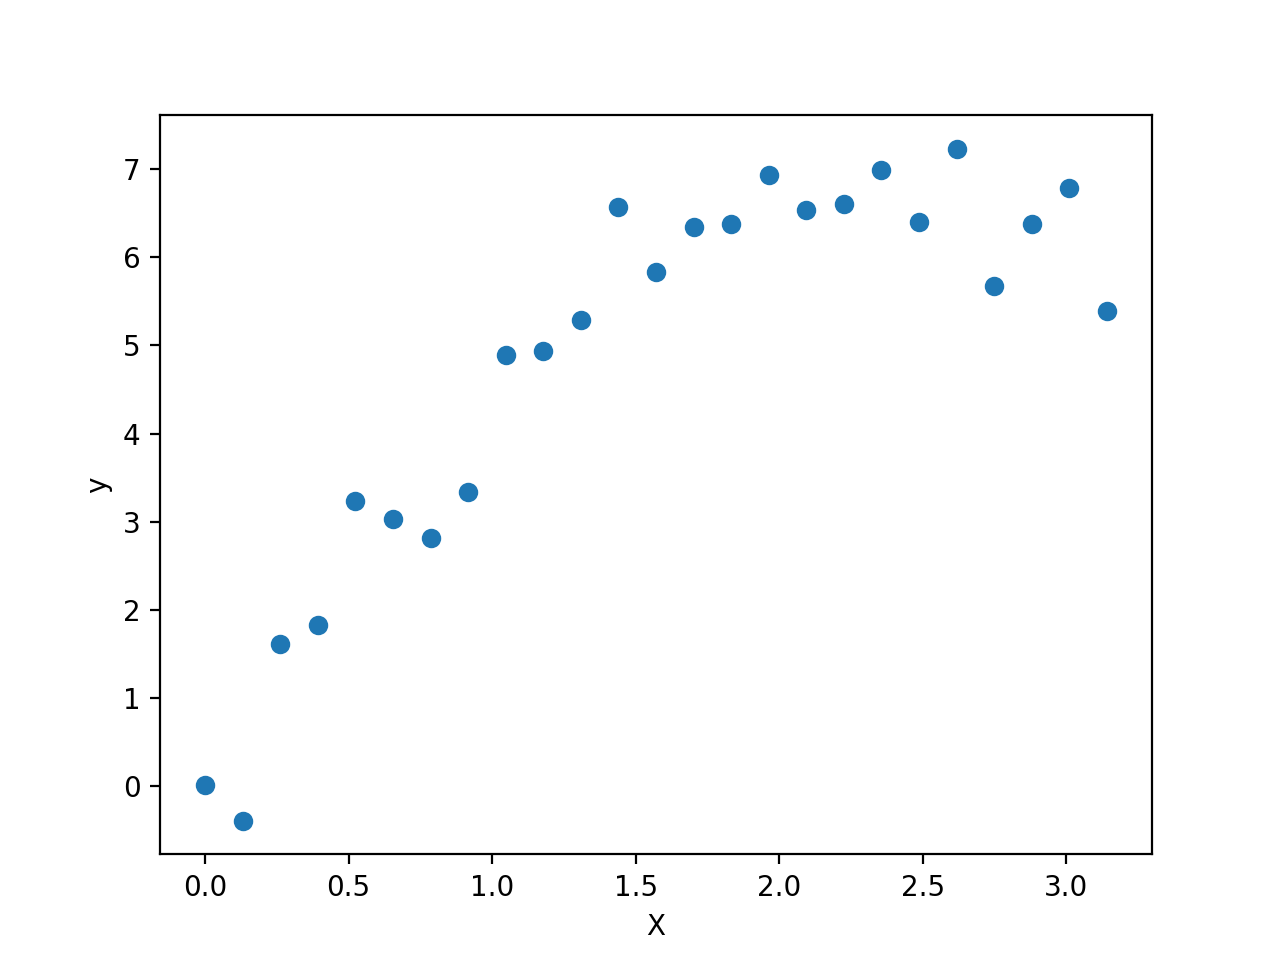

Text(0, 0.5, 'y')

In [5]:
model = AGraph(equation="3.0*sin(X_0) + 2.0*X_0")
X = np.linspace(0, np.pi, 25).reshape((-1,1))
y = model.evaluate_equation_at(X) + np.random.normal(0, 0.5, size=X.shape)
training_data = ExplicitTrainingData(x=X, y=y)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")

## (4) Initialize component generator, mutation and crossover objects, and AGraph generators ##

In [6]:
component_generator = ComponentGenerator(training_data.x.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("-")
component_generator.add_operator("*")
component_generator.add_operator("sin")
component_generator.add_operator("cos")

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)
agraph_generator = AGraphGenerator(STACK_SIZE,
                                   component_generator,
                                   use_simplification=True)

## (5) Initialize Bayesian fitness metric, parameter optimizer, and evaluator ##

In [7]:
fitness = ExplicitRegression(training_data=training_data)
local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
bff = BayesFitnessFunction(local_opt_fitness,
                           smc_hyperparams)
evaluator = Evaluation(bff)

## (5.1) Visualize True Model Uncertainty ##

<IPython.core.display.Javascript object>


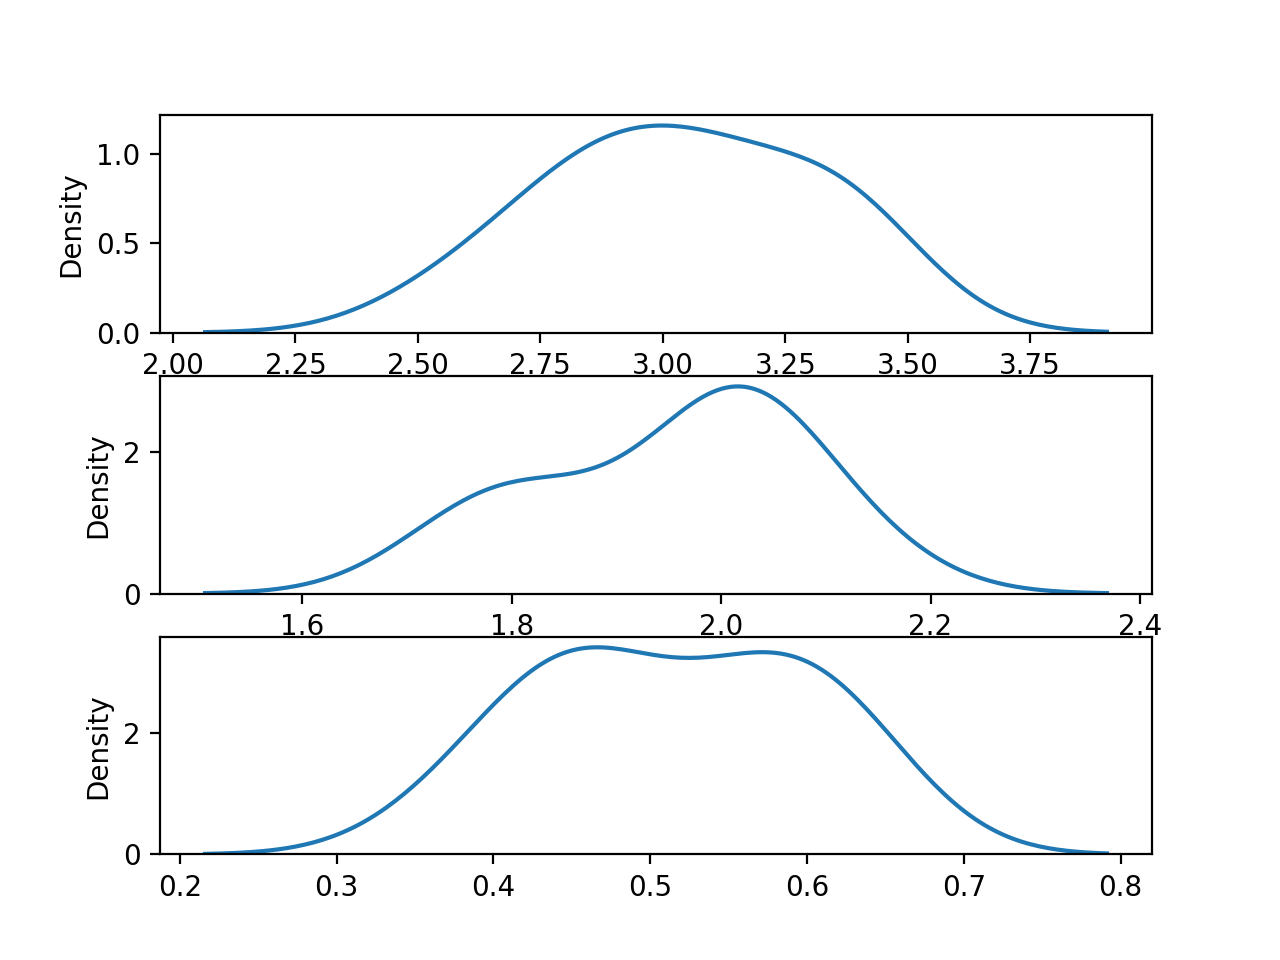

<AxesSubplot:ylabel='Density'>

In [8]:
nmll, step_list, vector_mcmc = bff(model, return_nmll_only=False)
params, weights = step_list[-1].params, step_list[-1].weights
fig, ax = plt.subplots(3)
sns.kdeplot(x=params[:,0].flatten(), weights=weights.flatten(), ax=ax[0])
sns.kdeplot(x=params[:,1].flatten(), weights=weights.flatten(), ax=ax[1])
sns.kdeplot(x=params[:,2].flatten(), weights=weights.flatten(), ax=ax[2])

<IPython.core.display.Javascript object>


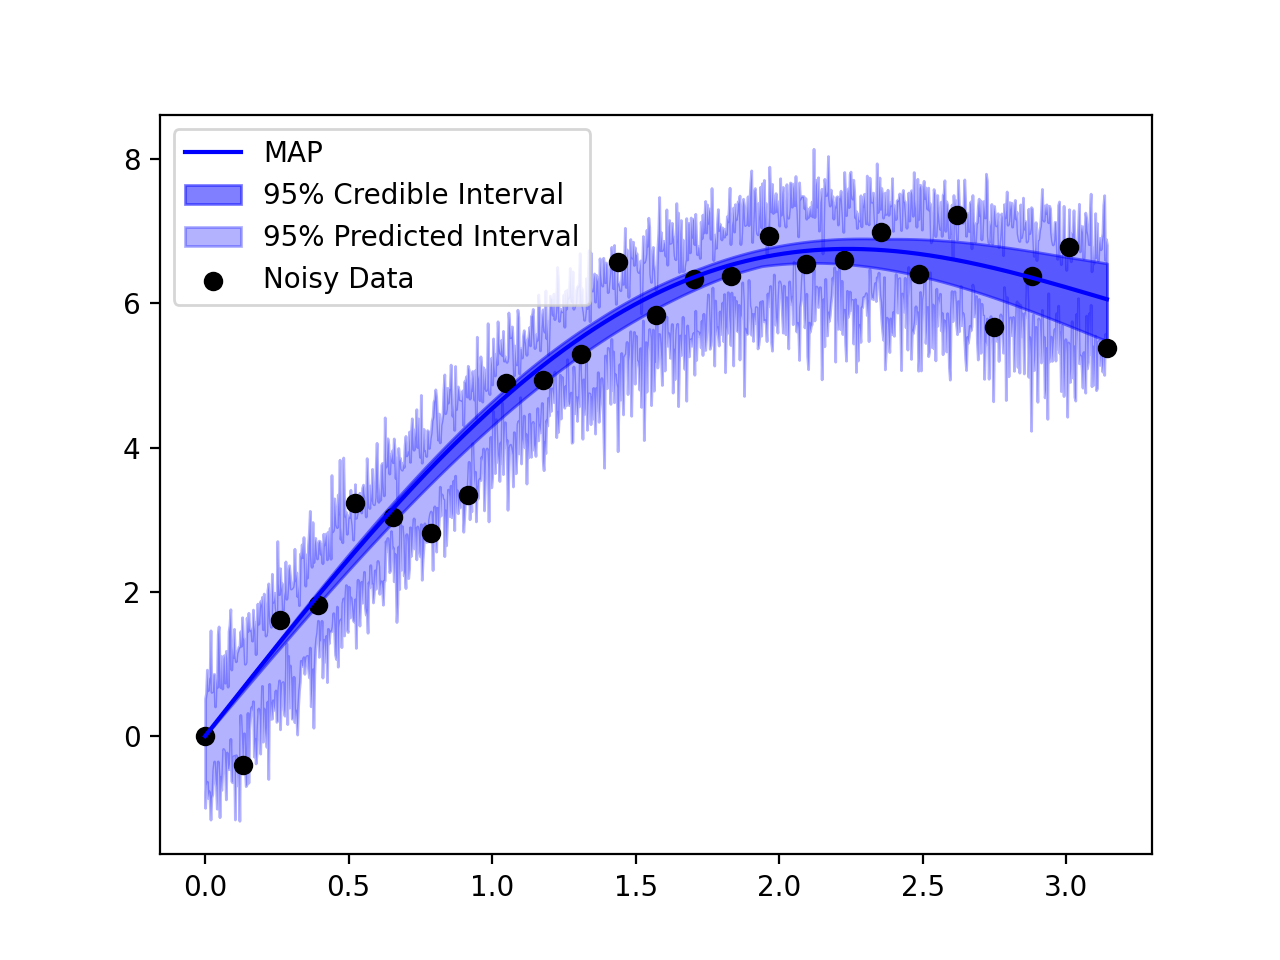

In [9]:
x, raw_data, cred, pred = bff.base_estimate_cred_pred(model, step_list, linspace=1000)
fig, ax = plt.subplots()

ax.plot(x, model.evaluate_equation_at(x), color="b", label="MAP")
ax.fill_between(x.flatten(), cred[:,0], cred[:,1], color="b",  alpha=0.5, label="95% Credible Interval")
ax.fill_between(x.flatten(), pred[:,0], pred[:,1], color="b",  alpha=0.3, label="95% Predicted Interval")
ax.scatter(raw_data[0], raw_data[1], color="k", label="Noisy Data")
ax.legend()


## (6) Initialize selection and evolutionary algorithm ##

In [10]:
selection_phase = BayesCrowding()
ea = GeneralizedCrowdingEA(evaluator, crossover,
                      mutation, 0.4, 0.4, selection_phase)

## (7) Initialize Bingo Island with Hall of Fame ##

In [11]:
def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 
def make_island():
    """
    Function created for repeated runs.
    """
    island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)
    return island

## (8) Run GPSR and Visualize Results ##

In [12]:
# Simple Visualization Code

def plot_best_n_individuals(ax, island, n=10):
    ax.clear()
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    idxs = np.argsort(fits)[:n]
    for i in idxs:
        ind = island.population[i]
        ax.plot(X, ind.evaluate_equation_at(X)) 
    ax.scatter(X, y, color="k", label="Training Data")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_ylim(0, 10)
    
def update_ax(ax, fig, x, y_mu, y_upper, y_lower):
    ax.clear()
    ax.set_ylim(0, 50)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Mean Fitness")
    ax.plot(x, y_mu, color="b")
    ax.fill_between(x, y_upper, y_lower, color="b", alpha=0.3)
    

<IPython.core.display.Javascript object>


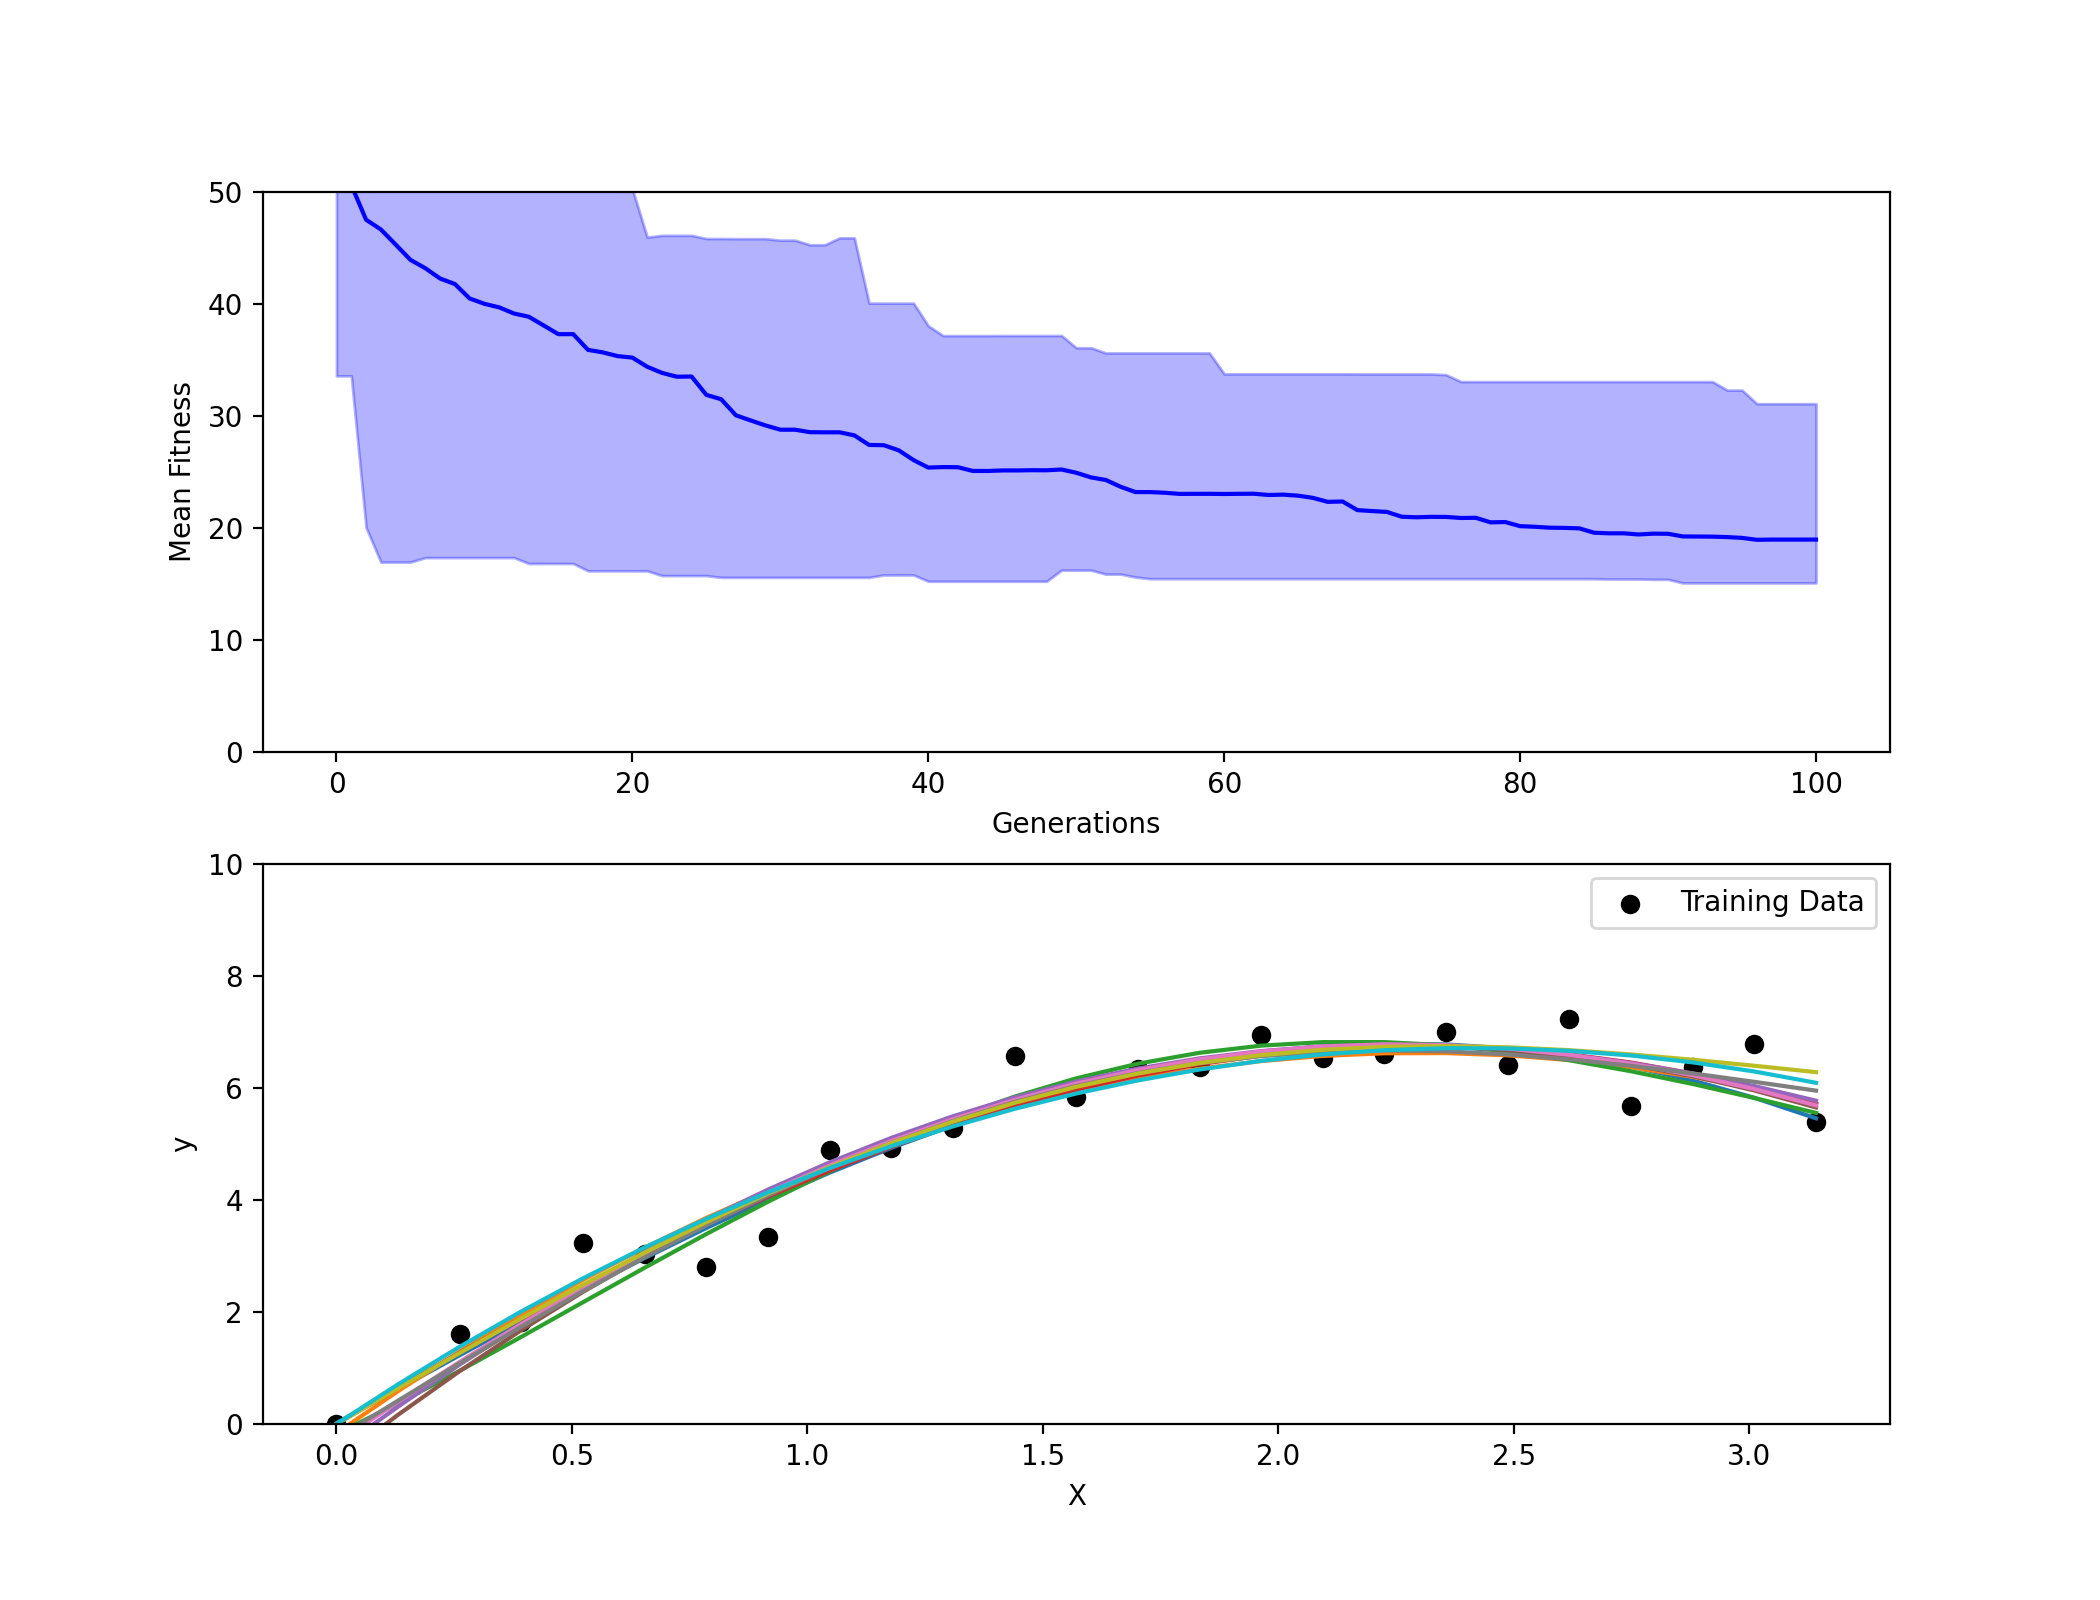

Text(0, 0.5, 'y')

In [13]:
fig, axs = plt.subplots(2, figsize=(10.5, 8))
axs[0].set_ylim(0, 1)
axs[1].scatter(X, y, color="k", label="Training Data")
axs[1].legend()
axs[0].set_ylim(0, 50)
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Mean Fitness")
axs[1].set_ylim(0, 10)
axs[1].set_xlabel("X")
axs[1].set_ylabel("y")

In [15]:
island = make_island()
#fig, axs = plt.subplots(2, figsize=(10.5, 8))
plt.show()
axs[0].set_xlabel("X")
axs[0].set_ylabel("y")

print("Best individual at initialization\n f(X_0) =", island.get_best_individual())
best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)
fits = [ind.fitness for ind in island.population]
means = [np.nanmean(fits)]
maxs = [np.nanmax(fits)]
mins = [np.nanmin(fits)]
fig.canvas.draw()

for i in tqdm(range(MAX_GENERATIONS)):
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)
        print(f"Best individual at generation {island.generational_age}\n f(X_0) =", island.get_best_individual())
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    means += [np.nanmean(fits)]
    maxs += [np.nanmax(fits)]
    mins += [np.nanmin(fits)]
    update_ax(axs[0], fig, np.arange(island.generational_age+1), np.array(means), np.array(maxs), np.array(mins))
    plot_best_n_individuals(axs[1], island, n=10)
    fig.canvas.draw()


Best individual at initialization
 f(X_0) = (-2.660017295294674)(-1.8005274805029343 + cos(X_0))


  2%|▊                                          | 2/100 [00:00<00:47,  2.04it/s]

Best individual at generation 2
 f(X_0) = (1.1700860937442774)((X_0)(4.789530239497244 - (X_0)))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
  3%|█▎                                         | 3/100 [00:01<00:44,  2.18it/s]

Best individual at generation 3
 f(X_0) = (1.187494298033413)((X_0)(4.744294826348584 - (X_0)))


  8%|███▍                                       | 8/100 [00:04<00:48,  1.92it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 10%|████▏                                     | 10/100 [00:04<00:43,  2.07it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 11%|████▌                                     | 11/100 [00:05<00:39,  2.26it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 12%|█████                                     | 12/100 [00:05<00:42,  2.07it/s]/Users/n

Best individual at generation 13
 f(X_0) = (X_0)(4.427059954385328 + (-0.27140486702110606)((X_0)(X_0)))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 15%|██████▎                                   | 15/100 [00:07<00:45,  1.88it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 16%|██████▋                                   | 16/100 [00:08<00:43,  1.93it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 17%|███████▏                                  | 17/100 [00:08<00:47,  1.76it/s]

Best individual at generation 17
 f(X_0) = -0.06770772615215746 + (5.728149971931284)(X_0) + (-1.2099905751169346)((X_0)(X_0))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 21%|████████▊                                 | 21/100 [00:10<00:44,  1.77it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 22%|█████████▏                                | 22/100 [00:11<00:45,  1.72it/s]

Best individual at generation 22
 f(X_0) = (2.001280950293974)(X_0) + (2.9129058877563807)(sin(X_0))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 23%|█████████▋                                | 23/100 [00:12<00:46,  1.67it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 25%|██████████▌                               | 25/100 [00:13<00:48,  1.55it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 26%|██████████▉                               | 26/100 [00:14<00:50,  1.47it/s]

Best individual at generation 26
 f(X_0) = (0.9929995984073787)(sin(X_0)) + (1.9324021753468936)(X_0 + sin(X_0))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 27%|███████████▎                              | 27/100 [00:15<00:52,  1.39it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 29%|████████████▏                             | 29/100 [00:16<00:46,  1.54it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 30%|████████████▌                             | 30/100 [00:16<00:43,  1.62it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matr

Best individual at generation 40
 f(X_0) = (6.843131304587862)(sin((0.6710799723414116)(X_0)))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 41%|█████████████████▏                        | 41/100 [00:24<00:46,  1.27it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 42%|█████████████████▋                        | 42/100 [00:25<00:44,  1.31it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 43%|██████████████████                        | 43/100 [00:26<00:40,  1.40it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matr

 67%|████████████████████████████▏             | 67/100 [00:44<00:22,  1.49it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 68%|████████████████████████████▌             | 68/100 [00:44<00:21,  1.47it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 69%|████████████████████████████▉             | 69/100 [00:45<00:22,  1.36it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 70%|█████████████████████████████▍            | 70/100 [00:46<00:21,  1.38it/s]/Users/n

Best individual at generation 91
 f(X_0) = (-1.0283144791082341)(X_0 - (cos(-0.9100114739833417))) + (9.256274066236681)(sin((cos(-0.9100114739833417))(X_0))) - (cos(-0.9100114739833417))


/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 93%|███████████████████████████████████████   | 93/100 [01:03<00:04,  1.54it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 94%|███████████████████████████████████████▍  | 94/100 [01:04<00:04,  1.31it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matrix is not positive definite; setting off-diagonal terms to zero.
  warnings.warn('Covariance matrix is not positive definite; setting '
 95%|███████████████████████████████████████▉  | 95/100 [01:05<00:04,  1.22it/s]/Users/nolanstrauss/codes/SMCPy/smcpy/smc/particles.py:192: UserWarning: Covariance matr

## Print Hall of Fame ###

In [16]:
for ind in island.hall_of_fame:
    print(f"model (fitness={ind.fitness}), fitness: {str(ind)}, {ind.fitness}")
    print()

model (fitness=14.653192391201234), fitness: -0.11744388269739624 + (2)(X_0) + (0.3294357951809901)((6.152402691417657 + (-2)(X_0))(-0.11744388269739624 + (2)(X_0))), 14.653192391201234

model (fitness=14.890165479570717), fitness: -0.7086796967266269 + cos(-0.7086796967266269) + (0.23150641058108043)(-0.7086796967266269 + X_0) + (-6.363103608777227)(sin((-0.7086796967266269)(X_0))), 14.890165479570717

model (fitness=15.005750010261306), fitness: (1.7210687741694972)(X_0) + (3.434555629575433)(cos(-1.6827999828290328 + X_0)), 15.005750010261306

model (fitness=15.245228172700665), fitness: (6.843131304587862)(sin((0.6710799723414116)(X_0))), 15.245228172700665

model (fitness=17.548058054025184), fitness: X_0 - ((X_0)(-4.142247274379922 + X_0)), 17.548058054025184

model (fitness=17.559213039373454), fitness: (X_0)(5.2241170175518254 - (X_0)), 17.559213039373454

model (fitness=36.87970277683932), fitness: (2.8163681468007287)(X_0), 36.87970277683932

model (fitness=44.920346052602156